In [1]:
%tensorflow_version 2.x

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [3]:
import sys
import os
sys.path.append('/content/gdrive/My Drive/ODA_CHALLENGE')
os.chdir('/content/gdrive/My Drive/ODA_CHALLENGE')
os.listdir()

['train.csv',
 'test.csv',
 'sample_submission.csv',
 'test_labels.csv',
 'data',
 'glove_helper.py',
 '__pycache__',
 'w266_common',
 'Toxic_Comment_challenge.ipynb']

In [1]:
import pandas as pd
import numpy as np
import re
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
import glove_helper
import random
import pickle
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pydot
import graphviz
from keras.utils import plot_model

In [6]:
!ls

data		 sample_submission.csv	Toxic_Comment_challenge.ipynb
glove_helper.py  test.csv		train.csv
__pycache__	 test_labels.csv	w266_common


In [9]:
#load data into pandas DF
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')

In [10]:
#check first 20 rows of the train df to get hang of the data
train_df.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [9]:
#describe the numeric columns
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
#check if any row has null
train_df[train_df.isnull().any(axis=1)]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


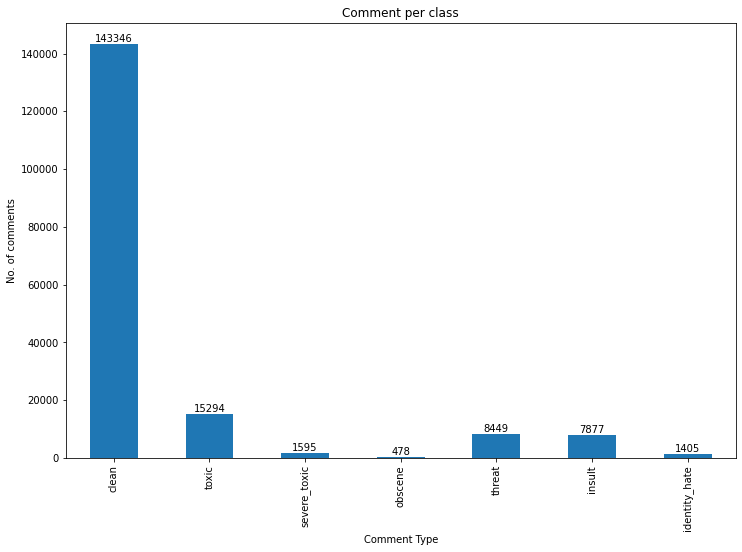

In [77]:
#Get a distribution of total number of comments for each category
clean_comment_number = len(train_df[(train_df["toxic"]==0) & 
                     (train_df["severe_toxic"]==0) & 
                     (train_df["obscene"]==0) & 
                     (train_df["threat"]==0) &
                     (train_df["insult"]==0) & 
                     (train_df["identity_hate"]==0)])
toxic_comment_number = len(train_df[train_df["toxic"]==1])
severe_toxic_comment_number =  len(train_df[train_df["severe_toxic"]==1])
obscene_comment_number = len(train_df[train_df["obscene"]==1])
threat_comment_number = len(train_df[train_df["threat"]==1])
insult_comment_number = len(train_df[train_df["insult"]==1])
identity_hate_comment_number = len(train_df[train_df["identity_hate"]==1])
frequencies = [clean_comment_number , 
               toxic_comment_number , 
               severe_toxic_comment_number ,
               threat_comment_number ,
               obscene_comment_number ,
               insult_comment_number ,
               identity_hate_comment_number]
freq_series = pd.Series(frequencies)
x_labels = ["clean" , "toxic" , "severe_toxic" , "obscene" ,"threat" , "insult" , "identity_hate"]
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_title('Comment per class')
ax.set_xlabel("Comment Type")
ax.set_ylabel('No. of comments')
ax.set_xticklabels(x_labels)
rects = ax.patches
for rect , label in zip(rects , frequencies):
  height = rect.get_height()
  ax.text(rect.get_x() + rect.get_width() / 2, 
          height + 5, 
          label,
          ha='center', va='bottom')
plt.show()

In [11]:
#Data Cleaning
#clean the comment_text by removing the punctuations digits and stop words and lower the text
#remove the \n and \t and also expand common contraction
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "i'd": "i would", "i'd've": "i would have","i'll": "i will",
                     "i'll've": "i will have","i'm": "i am","i've": "i have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have","she's":"she is","he's":"he is"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

def preprocess_text(sen):
    
    #expand contractions 
    sentence = expand_contractions(sen.lower())
    # Removing \n and \t
    sentence = sentence.replace('\t',' ')
    sentence = sentence.replace('\n',' ')
    # Remove punctuations and foreign characters and digits
    sentence = ' '.join(re.sub(r'[^A-Za-z ]+', '', sentence).split())

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+",' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+',' ', sentence)

    return sentence

train_df['comment_text'] = train_df['comment_text'].apply(lambda x: preprocess_text(str(x))) 
test_df['comment_text'] = test_df['comment_text'].apply(lambda x: preprocess_text(str(x)))
#train_df['comment_text'] = train_df['comment_text'].str.replace('\t',' ') 
#test_df['comment_text'] = test_df['comment_text'].str.replace('\t',' ')
#train_df['comment_text'] = train_df['comment_text'].str.replace('\d+', ' ')
#test_df['comment_text'] = test_df['comment_text'].str.replace('\d+', ' ')
#train_df['comment_text'] = train_df['comment_text'].str.lower()
#test_df['comment_text'] = test_df['comment_text'].str.lower()
#train_df['comment_text'] = train_df['comment_text'].str.replace("[^a-z ]",'')
#test_df['comment_text'] = test_df['comment_text'].str.replace("[^a-z ]",'')

In [48]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
stop = stopwords.words('english')
train_df['comment_text'] = train_df['comment_text'].apply(lambda x : ' '.join([y for y in x.split() if y not in stop]))
test_df['comment_text'] = test_df['comment_text'].apply(lambda x : ' '.join([y for y in x.split() if y not in stop]))


In [14]:
train_df.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww matches background colour seemingly stuck...,0,0,0,0,0,0
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,cannot make real suggestions improvement wonde...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0
5,00025465d4725e87,congratulations well use tools well talk,0,0,0,0,0,0
6,0002bcb3da6cb337,cocksucker piss around work,1,1,1,0,1,0
7,00031b1e95af7921,vandalism matt shirvington article reverted pl...,0,0,0,0,0,0
8,00037261f536c51d,sorry word nonsense offensive anyway intending...,0,0,0,0,0,0
9,00040093b2687caa,alignment subject contrary dulithgow,0,0,0,0,0,0


In [15]:
#get the maximum words in train comments
train_df['comment_text'].str.split().str.len().max()

1250

In [16]:
train_df['comment_length'] = train_df['comment_text'].str.split().str.len()

In [17]:
train_df[train_df['comment_length'] == 1250]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
32143,5572234220e43ea2,pig pig pig pig pig pig pig pig pig pig pig pi...,1,0,0,0,0,0,1250
61793,a55e3736cb1c2db1,oh noes oh noes oh noes oh noes oh noes oh noe...,0,0,0,0,0,0,1250
76598,cd135d9358a9e9ea,die fag die fag die fag die fag die fag die fa...,1,0,0,0,0,0,1250
150039,65d66bf057752682,lol lol lol lol lol lol lol lol lol lol lol lo...,0,0,0,0,0,0,1250


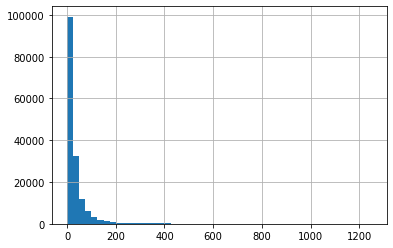

In [18]:
#histogram of comment length
train_df['comment_length'].hist(bins=50)

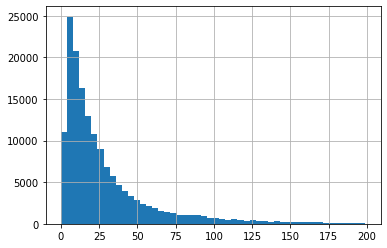

In [19]:
#histogram of comment length where comment length < 200
train_df[train_df['comment_length'] < 200]['comment_length'].hist(bins=50)

In [13]:
#create tokenizer to create tokens from the raw data
def tokenize_data(dataset,num_words=None):
    tokenizer = Tokenizer(num_words,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"''",oov_token='<unk>')
    tokenizer.fit_on_texts(dataset)
    vocab = {}
    for word,i in tokenizer.word_index.items():
        if num_words is not None:
            if i <= num_words:
                vocab[word] = i
        else:
            vocab[word] = i
    #vocab = tokenizer.word_index
    id_vocab = {value: key for key, value in vocab.items()}
    return (tokenizer,vocab,id_vocab)

In [22]:
tokenizer,vocab,id_vocab = tokenize_data(train_df['comment_text'])

In [23]:
#get the length of vocabulary 
len(vocab)

219450

In [14]:
#Based on above EDA we fix the following
ndim = 300
max_features = 100000
max_len = 150

In [15]:
tokenizer,vocab,id_vocab = tokenize_data(train_df['comment_text'],num_words=max_features)

In [16]:
vocab_size = len(vocab)
print(vocab_size)

100000


In [17]:
#Use Glove as pre-trained Word Embeddings
def create_embedding_matrix(word_index,vocab_size=50000,ndim=100):
    hands = glove_helper.Hands(ndim)
    embedding_matrix = np.zeros((vocab_size+1,ndim))
    for word,i in word_index.items():
        if i<=vocab_size:
            embedding_vector = hands.get_vector(word,strict=False)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix
embedding_matrix = create_embedding_matrix(vocab,vocab_size,ndim)
embedding_matrix.shape

Loading vectors from data/glove/glove.6B.zip
Parsing file: data/glove/glove.6B.zip:glove.6B.300d.txt
Found 400,000 words.
Parsing vectors... Done! (W.shape = (400003, 300))


(100001, 300)

In [15]:
#get the list X and Y from training 
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_df[classes].values
X = train_df['comment_text']

def vectorize_data(tokenizer_obj,text,max_len):
    text_seq = tokenizer_obj.texts_to_sequences(text)
    text_seq_padded = pad_sequences(text_seq,max_len,padding='post', truncating='post')
    return text_seq_padded

X_padded = vectorize_data(tokenizer,X,max_len)


In [16]:
#Split training and Validation set
X_train,X_valid, Y_train, Y_valid = train_test_split(X_padded, y, test_size = 0.1,random_state=42)

In [17]:
print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)

(143613, 150)
(15958, 150)
(143613, 6)
(15958, 6)


In [4]:
#Create a model with certain hyperparameters
#We are creating a model where we would have a series of Bidirectional LSTM on top of Word Embeddings
#Then on top of LSTM outputs we will have CNN(CONV1D) layers of 2,3 and 4 filter sizes
#Then we concatenate the CNN layer outputs and feed to deep Dense Layers
#Last layer is 6 units with sigmoid activation which will tell the probablity of that class
#The Embedding layer is set as not trainable as we are using GLOVE embeddings
def create_model(embedding_matrix,
                 num_unit_lstm = 128,
                 num_layers_lstm = 2,
                 num_dense_layer_units = 128,
                 dropout_rate = 0.5,
                 num_dense_layers = 2,
                 cnn_num_filters = 200
                 ):
    input_layer = layers.Input(shape=(max_len,),name='Input_layer')
    Enbedding_layer = Embedding(max_features+1,
                                ndim,
                                mask_zero=True,
                                name='Embedding_layer')(input_layer)
    for i in range(num_layers_lstm):
        if i ==0 :
            bidirection_layer = layers.Bidirectional(layers.LSTM(num_unit_lstm,
                                                          return_sequences=True,
                                                          dropout=dropout_rate,
                                                          #recurrent_dropout=dropout_rate,
                                                          recurrent_initializer='glorot_uniform',
                                                          name="bid"+str(i)))(Enbedding_layer)
        else:
            bidirection_layer = layers.Bidirectional(layers.LSTM(num_unit_lstm,
                                                          return_sequences=True,
                                                          dropout=dropout_rate,
                                                          #recurrent_dropout=dropout_rate,
                                                          recurrent_initializer='glorot_uniform',
                                                          name="bid"+str(i)))(bidirection_layer)
    
    cnn_layer1 = layers.Conv1D(filters=cnn_num_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")(bidirection_layer)
    cnn_layer1 = layers.GlobalMaxPool1D()(cnn_layer1)
    cnn_layer2 = layers.Conv1D(filters=cnn_num_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")(bidirection_layer)
    cnn_layer2 = layers.GlobalMaxPool1D()(cnn_layer2)
    cnn_layer3 = layers.Conv1D(filters=cnn_num_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")(bidirection_layer)
    cnn_layer3 = layers.GlobalMaxPool1D()(cnn_layer3)

    concatenated = tf.concat([cnn_layer1, cnn_layer2, cnn_layer3], axis=-1)
    for j in range(num_dense_layers):
        if j == 0:
            dense = layers.Dense(units=num_dense_layer_units)(concatenated)
            dense = layers.BatchNormalization()(dense)
            dense = layers.Activation('relu')(dense)
            dropout = layers.Dropout(rate=dropout_rate)(dense)
        else:
            dense = layers.Dense(units=num_dense_layer_units)(dropout)
            dense = layers.BatchNormalization()(dense)
            dense = layers.Activation('relu')(dense)
            dropout = layers.Dropout(rate=dropout_rate)(dense)
    
    Dense_layer_final = layers.Dense(6,activation='sigmoid',name='Dense_layer_final')(dropout)
    model = Model(input_layer,Dense_layer_final)
    model.get_layer("Embedding_layer").set_weights([embedding_matrix])
    model.get_layer("Embedding_layer").trainable = False
    return model

In [32]:
#Create parameter space for hyperaparameters
num_unit_lstm_list = [64,128,160,256]
num_layers_lstm_list = [2,3,4]
num_dense_layer_units_list = [64,128,160,256]
dropout_rate_list = [0.2,0.3,0.4,0.5]
num_dense_layers_list = [2,3,4]
cnn_num_filters_list = [100,150,200,250]

In [ ]:
#create 4 experiments using random search on hyperparameters
Experiment_Dic = {}
for i in range(4):
    Experiment_Dic['Experiment'+str(i)] = {}
    Experiment_Dic['Experiment'+str(i)]['num_unit_lstm']=random.choice(num_unit_lstm_list)
    Experiment_Dic['Experiment'+str(i)]['num_layers_lstm'] =random.choice(num_layers_lstm_list)
    Experiment_Dic['Experiment'+str(i)]['num_dense_layer_units']=random.choice(num_dense_layer_units_list)
    Experiment_Dic['Experiment'+str(i)]['dropout_rate']=random.choice(dropout_rate_list)
    Experiment_Dic['Experiment'+str(i)]['num_dense_layers']=random.choice(num_dense_layers_list)
    Experiment_Dic['Experiment'+str(i)]['cnn_num_filters']=random.choice(cnn_num_filters_list)

print(Experiment_Dic)

{'Experiment0': {'num_unit_lstm': 160, 'num_layers_lstm': 4, 'num_dense_layer_units': 64, 'dropout_rate': 0.2, 'num_dense_layers': 2, 'cnn_num_filters': 200}, 'Experiment1': {'num_unit_lstm': 160, 'num_layers_lstm': 3, 'num_dense_layer_units': 256, 'dropout_rate': 0.4, 'num_dense_layers': 4, 'cnn_num_filters': 200}, 'Experiment2': {'num_unit_lstm': 160, 'num_layers_lstm': 4, 'num_dense_layer_units': 160, 'dropout_rate': 0.2, 'num_dense_layers': 2, 'cnn_num_filters': 150}, 'Experiment3': {'num_unit_lstm': 64, 'num_layers_lstm': 4, 'num_dense_layer_units': 256, 'dropout_rate': 0.3, 'num_dense_layers': 3, 'cnn_num_filters': 150}}


In [2]:
Experiment_Dic = {'Experiment0': {'num_unit_lstm': 160, 
                                  'num_layers_lstm': 4, 
                                  'num_dense_layer_units': 64, 
                                  'dropout_rate': 0.2, 
                                  'num_dense_layers': 2, 
                                  'cnn_num_filters': 200}, 
                  'Experiment1': {'num_unit_lstm': 160, 
                                  'num_layers_lstm': 3, 
                                  'num_dense_layer_units': 256, 
                                  'dropout_rate': 0.4, 
                                  'num_dense_layers': 4, 
                                  'cnn_num_filters': 200}, 
                  'Experiment2': {'num_unit_lstm': 160, 
                                  'num_layers_lstm': 4, 
                                  'num_dense_layer_units': 160, 
                                  'dropout_rate': 0.2, 
                                  'num_dense_layers': 2, 
                                  'cnn_num_filters': 150}, 
                  'Experiment3': {'num_unit_lstm': 64, 
                                  'num_layers_lstm': 4, 
                                  'num_dense_layer_units': 256, 
                                  'dropout_rate': 0.3, 
                                  'num_dense_layers': 3, 
                                  'cnn_num_filters': 150}}

In [30]:
#Function which will actually run the experiments
# Has provision to run on TPU if TPU accelarated environment is being used
def run_experiment(Experiment_Dic,
                   Experiment_No,
                   embedding_matrix,
                   tpu_enabled = 0):
    ExperimentNo = 'Experiment'+str(Experiment_No)
    print("Running ",ExperimentNo)
    num_unit_lstm = Experiment_Dic[ExperimentNo]['num_unit_lstm']
    num_layers_lstm = Experiment_Dic[ExperimentNo]['num_layers_lstm']
    num_dense_layer_units = Experiment_Dic[ExperimentNo]['num_dense_layer_units']
    dropout_rate = Experiment_Dic[ExperimentNo]['dropout_rate']
    num_dense_layers = Experiment_Dic[ExperimentNo]['num_dense_layers']
    cnn_num_filters = Experiment_Dic[ExperimentNo]['cnn_num_filters']
    if tpu_enabled==0:
      precision_obj = keras.metrics.Precision()
      recall_obj = keras.metrics.Recall()
      model = create_model(embedding_matrix,
                   num_unit_lstm,
                   num_layers_lstm,
                   num_dense_layer_units,
                   dropout_rate,
                   num_dense_layers,
                   cnn_num_filters)
    
      model.compile(
                     optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy',precision_obj,recall_obj]
                   )
    else:
      resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' +
                                                                    os.environ['COLAB_TPU_ADDR'])
      tf.config.experimental_connect_to_cluster(resolver)
      tf.tpu.experimental.initialize_tpu_system(resolver)
      strategy = tf.distribute.experimental.TPUStrategy(resolver)
      batch_size = 128*8 #need to make batch size multiple of 8 as each worker has 8 cores
      with strategy.scope():
        precision_obj = keras.metrics.Precision()
        recall_obj = keras.metrics.Recall()
        model = create_model(embedding_matrix,
                  num_unit_lstm,
                  num_layers_lstm,
                  num_dense_layer_units,
                  dropout_rate,
                  num_dense_layers,
                  cnn_num_filters)
  
        model.compile(
                      optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy',precision_obj,recall_obj]
                    )
    #Use early stopping and model checkpoints to save the best model
    filepath=ExperimentNo+"_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
    mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_accuracy', mode='max')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
    if tpu_enabled ==0:
      batch_size = 32
      epoch = 20
      num_train = 10240 #if not using TPU then number of training example is less
    else:
      batch_size = 128 *8 
      epoch = 50 # make number of epochs more as batch size is larger on TPU
      num_train = (X_train.shape[0]//batch_size)*batch_size #For TPU the number of training example needs to be 
                                                            # multiple of batch size
    history = model.fit(
                        X_train[:num_train],
                        Y_train[:num_train],
                        validation_split=0.1,
                        callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
                        batch_size=batch_size,
                        shuffle=True,
                        epochs=epoch)
    #Save the history
    with open(ExperimentNo+'_model_history', 'wb') as file_history:
        pickle.dump(history.history, file_history)
    

In [31]:
#Run the experiments
for i in range(4):
    run_experiment(Experiment_Dic,
                   i,
                   embedding_matrix,
                   1)

Running  Experiment0


INFO:tensorflow:Initializing the TPU system: grpc://10.39.252.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.39.252.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/50
  2/126 [..............................] - ETA: 9s - loss: 0.9657 - accuracy: 0.1079 - precision_8: 0.0442 - recall_8: 0.6761WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0080s vs `on_train_batch_end` time: 0.1383s). Check your callbacks.


126/126 [==============================] - ETA: 0s - loss: 0.3372 - accuracy: 0.1574 - precision_8: 0.1651 - recall_8: 0.4199WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0020s vs `on_test_batch_end` time: 0.0451s). Check your callbacks.


126/126 [==============================] - 30s 235ms/step - loss: 0.3372 - accuracy: 0.1574 - precision_8: 0.1651 - recall_8: 0.4199 - val_loss: 0.1137 - val_accuracy: 0.3061 - val_precision_8: 0.7473 - val_recall_8: 0.5519
Epoch 2/50
126/126 [==============================] - 21s 165ms/step - loss: 0.1025 - accuracy: 0.3112 - precision_8: 0.7677 - recall_8: 0.5236 - val_loss: 0.0697 - val_accuracy: 0.3636 - val_precision_8: 0.7684 - val_recall_8: 0.5952
Epoch 3/50
126/126 [==============================] - 21s 166ms/step - loss: 0.0739 - accuracy: 0.4204 - precision_8: 0.7850 - recall_8: 0.5717 - val_loss: 0.0614 - val_accuracy: 0.5022 - val_precision_8: 0.7898 - val_recall_8: 0.5939
Epoch 4/50
126/126 [==============================] - 21s 165ms/step - loss: 0.0635 - accuracy: 0.5161 - precision_8: 0.7997 - recall_8: 0.5980 - val_loss: 0.0582 - val_accuracy: 0.5650 - val_precision_8: 0.7937 - val_recall_8: 0.6115
Epoch 5/50
126/126 [==============================] - 21s 163ms/step - 

INFO:tensorflow:Initializing the TPU system: grpc://10.39.252.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.39.252.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/50
  2/126 [..............................] - ETA: 7s - loss: 0.7449 - accuracy: 0.1089 - precision_9: 0.0372 - recall_9: 0.4260WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0040s vs `on_train_batch_end` time: 0.1068s). Check your callbacks.


126/126 [==============================] - ETA: 0s - loss: 0.1615 - accuracy: 0.2869 - precision_9: 0.2887 - recall_9: 0.3713WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0028s vs `on_test_batch_end` time: 0.0367s). Check your callbacks.


126/126 [==============================] - 27s 210ms/step - loss: 0.1615 - accuracy: 0.2869 - precision_9: 0.2887 - recall_9: 0.3713 - val_loss: 0.0856 - val_accuracy: 0.1652 - val_precision_9: 0.7070 - val_recall_9: 0.5977
Epoch 2/50
126/126 [==============================] - 17s 138ms/step - loss: 0.0690 - accuracy: 0.5067 - precision_9: 0.7660 - recall_9: 0.5493 - val_loss: 0.0720 - val_accuracy: 0.6229 - val_precision_9: 0.5926 - val_recall_9: 0.7567
Epoch 3/50
126/126 [==============================] - 17s 139ms/step - loss: 0.0617 - accuracy: 0.6093 - precision_9: 0.7889 - recall_9: 0.5769 - val_loss: 0.0577 - val_accuracy: 0.8012 - val_precision_9: 0.7344 - val_recall_9: 0.6808
Epoch 4/50
126/126 [==============================] - 17s 137ms/step - loss: 0.0584 - accuracy: 0.6699 - precision_9: 0.7996 - recall_9: 0.5999 - val_loss: 0.0561 - val_accuracy: 0.9385 - val_precision_9: 0.7566 - val_recall_9: 0.6588
Epoch 5/50
126/126 [==============================] - 17s 138ms/step - 

INFO:tensorflow:Initializing the TPU system: grpc://10.39.252.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.39.252.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/50
  2/126 [..............................] - ETA: 8s - loss: 0.7738 - accuracy: 0.1724 - precision_10: 0.0347 - recall_10: 0.4865WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0041s vs `on_train_batch_end` time: 0.1322s). Check your callbacks.


126/126 [==============================] - ETA: 0s - loss: 0.1624 - accuracy: 0.3256 - precision_10: 0.3611 - recall_10: 0.5010WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0022s vs `on_test_batch_end` time: 0.0446s). Check your callbacks.


126/126 [==============================] - 29s 231ms/step - loss: 0.1624 - accuracy: 0.3256 - precision_10: 0.3611 - recall_10: 0.5010 - val_loss: 0.0756 - val_accuracy: 0.6157 - val_precision_10: 0.7249 - val_recall_10: 0.6206
Epoch 2/50
126/126 [==============================] - 21s 164ms/step - loss: 0.0648 - accuracy: 0.5391 - precision_10: 0.7935 - recall_10: 0.5881 - val_loss: 0.0595 - val_accuracy: 0.8770 - val_precision_10: 0.7701 - val_recall_10: 0.6375
Epoch 3/50
126/126 [==============================] - 19s 152ms/step - loss: 0.0573 - accuracy: 0.6206 - precision_10: 0.8032 - recall_10: 0.6190 - val_loss: 0.0548 - val_accuracy: 0.6365 - val_precision_10: 0.7872 - val_recall_10: 0.6262
Epoch 4/50
126/126 [==============================] - 19s 148ms/step - loss: 0.0536 - accuracy: 0.6722 - precision_10: 0.8075 - recall_10: 0.6398 - val_loss: 0.0532 - val_accuracy: 0.8103 - val_precision_10: 0.7866 - val_recall_10: 0.6240
Epoch 5/50
126/126 [==============================] - 1

INFO:tensorflow:Initializing the TPU system: grpc://10.39.252.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.39.252.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/50
  2/126 [..............................] - ETA: 5s - loss: 0.6879 - accuracy: 0.1812 - precision_11: 0.0370 - recall_11: 0.4327WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0058s vs `on_train_batch_end` time: 0.0808s). Check your callbacks.


126/126 [==============================] - ETA: 0s - loss: 0.1383 - accuracy: 0.4119 - precision_11: 0.3829 - recall_11: 0.4181WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_test_batch_end` time: 0.0298s). Check your callbacks.


126/126 [==============================] - 22s 173ms/step - loss: 0.1383 - accuracy: 0.4119 - precision_11: 0.3829 - recall_11: 0.4181 - val_loss: 0.0804 - val_accuracy: 0.8756 - val_precision_11: 0.8898 - val_recall_11: 0.3923
Epoch 2/50
126/126 [==============================] - 14s 111ms/step - loss: 0.0640 - accuracy: 0.6311 - precision_11: 0.7843 - recall_11: 0.5748 - val_loss: 0.0598 - val_accuracy: 0.9823 - val_precision_11: 0.7980 - val_recall_11: 0.5898
Epoch 3/50
126/126 [==============================] - 12s 99ms/step - loss: 0.0583 - accuracy: 0.7093 - precision_11: 0.7986 - recall_11: 0.6030 - val_loss: 0.0569 - val_accuracy: 0.8487 - val_precision_11: 0.8190 - val_recall_11: 0.5717
Epoch 4/50
126/126 [==============================] - 12s 95ms/step - loss: 0.0556 - accuracy: 0.7328 - precision_11: 0.8032 - recall_11: 0.6136 - val_loss: 0.0545 - val_accuracy: 0.7792 - val_precision_11: 0.7696 - val_recall_11: 0.6422
Epoch 5/50
126/126 [==============================] - 12s

In [34]:
#Plot Accuracy,Loss,Precision,Recall for experiments
def plot_experiments(ExperimentNumber):
    ExperimentNo = "Experiment"+str(ExperimentNumber)
    if ( os.path.exists(ExperimentNo+'_model_history')) :
        
        with open(ExperimentNo+'_model_history', 'rb') as file_history:
            history = pickle.load( file_history )

        fig, axs = plt.subplots(2, 2,figsize=(15,15))
        fig.suptitle('++++++++++++++++++++++++'+ExperimentNo+'++++++++++++++++++++++',fontsize=14)
        # Plot training & validation accuracy values
        axs[0, 0].plot(history['accuracy'])
        axs[0, 0].plot(history['val_accuracy'])
        axs[0, 0].set_title(ExperimentNo+' Model accuracy')
        axs[0, 0].set_ylabel('Accuracy')
        axs[0, 0].set_xlabel('Epoch')
        axs[0, 0].legend(['Train', 'Val'], loc='upper left')
        #plt.show()

        # Plot training & validation loss values
        axs[0, 1].plot(history['loss'])
        axs[0, 1].plot(history['val_loss'])
        axs[0, 1].set_title(ExperimentNo+' Model loss')
        axs[0, 1].set_ylabel('Binary Entropy Loss')
        axs[0, 1].set_xlabel('Epoch')
        axs[0, 1].legend(['Train', 'Val'], loc='upper left')
        #plt.show()


        
        for k in range(100):
          if history.get('precision_'+str(k),-1) != -1 :
            precision = 'precision_'+str(k)
            val_precision = 'val_precision_'+str(k)
            recall = 'recall_'+str(k)
            val_recall = 'val_recall_'+str(k)
            break
        # Plot training & validation precision values
        axs[1, 0].plot(history[precision])
        axs[1, 0].plot(history[val_precision])
        axs[1, 0].set_title(ExperimentNo+' Model precision')
        axs[1, 0].set_ylabel('Precision')
        axs[1, 0].set_xlabel('Epoch')
        axs[1, 0].legend(['Train', 'Val'], loc='upper left')
        #plt.show()

        # Plot training & validation recall values
        axs[1, 1].plot(history[recall])
        axs[1, 1].plot(history[val_recall])
        axs[1, 1].set_title(ExperimentNo+' Model recall')
        axs[1, 1].set_ylabel('Recall')
        axs[1, 1].set_xlabel('Epoch')
        axs[1, 1].legend(['Train', 'Val'], loc='upper left')
        #plt.show()

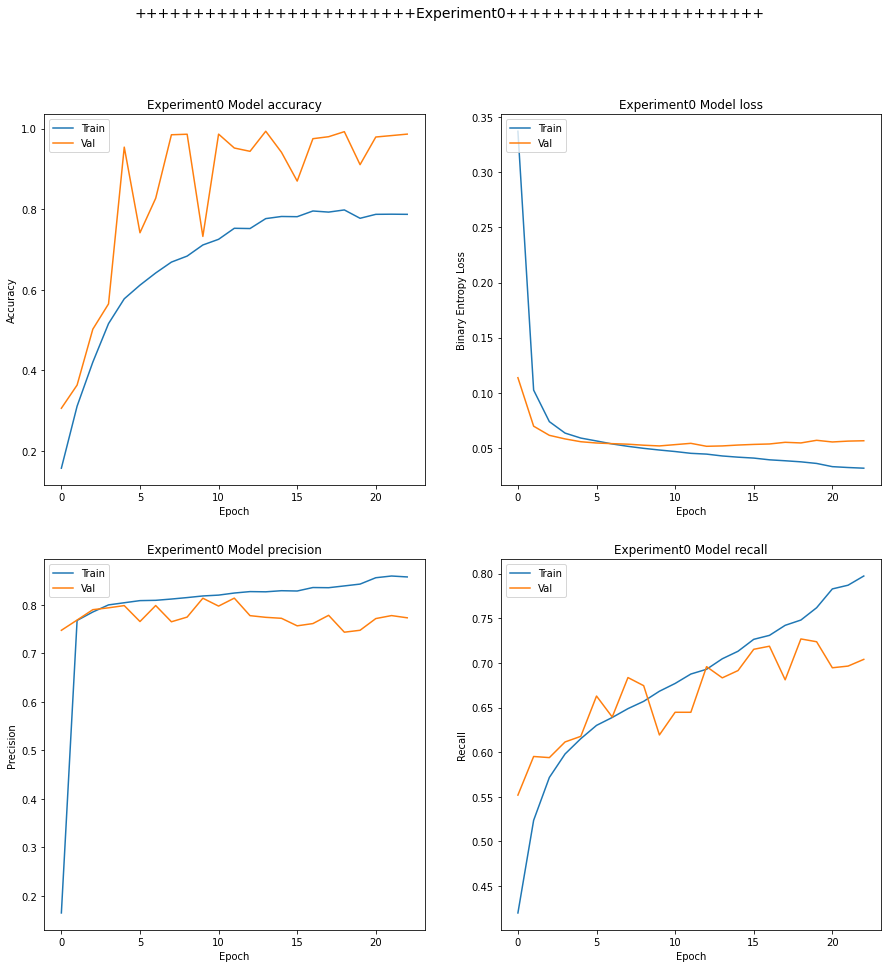

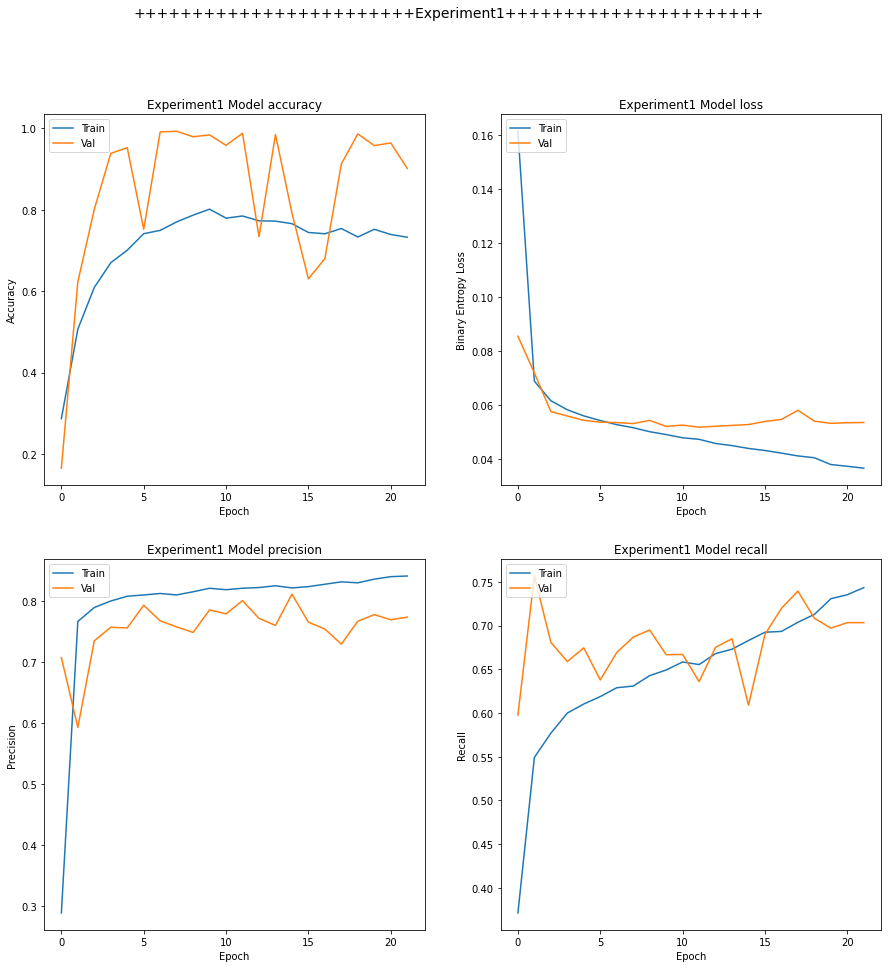

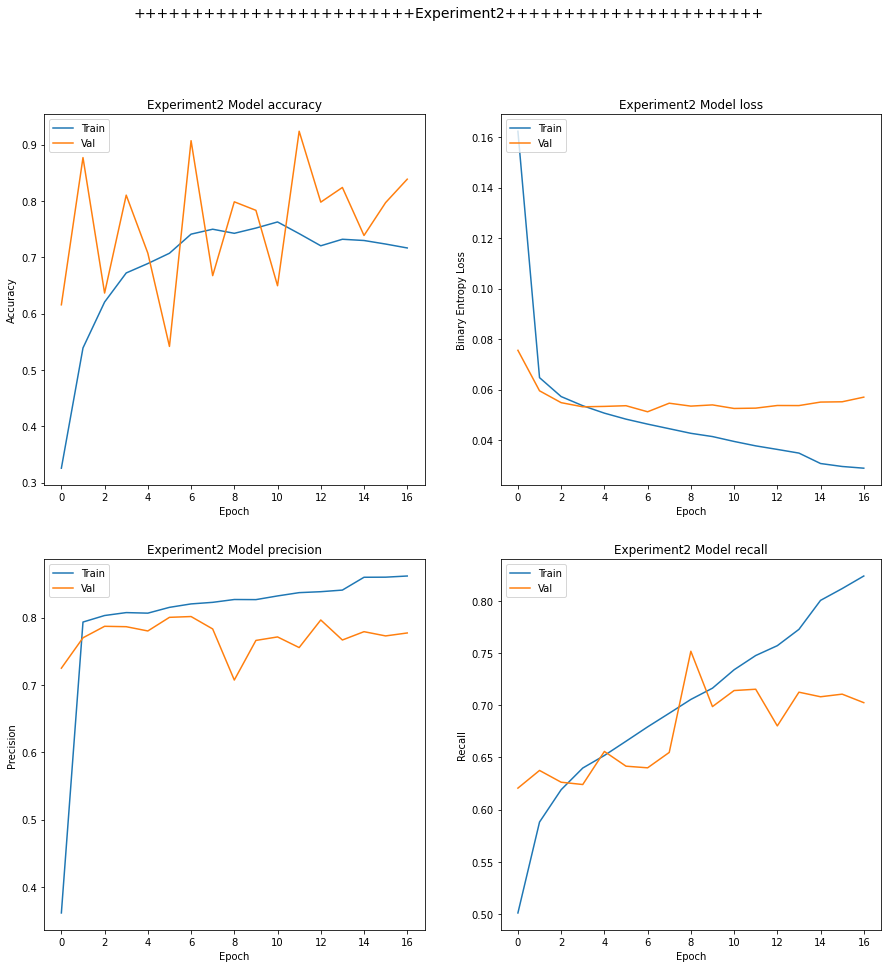

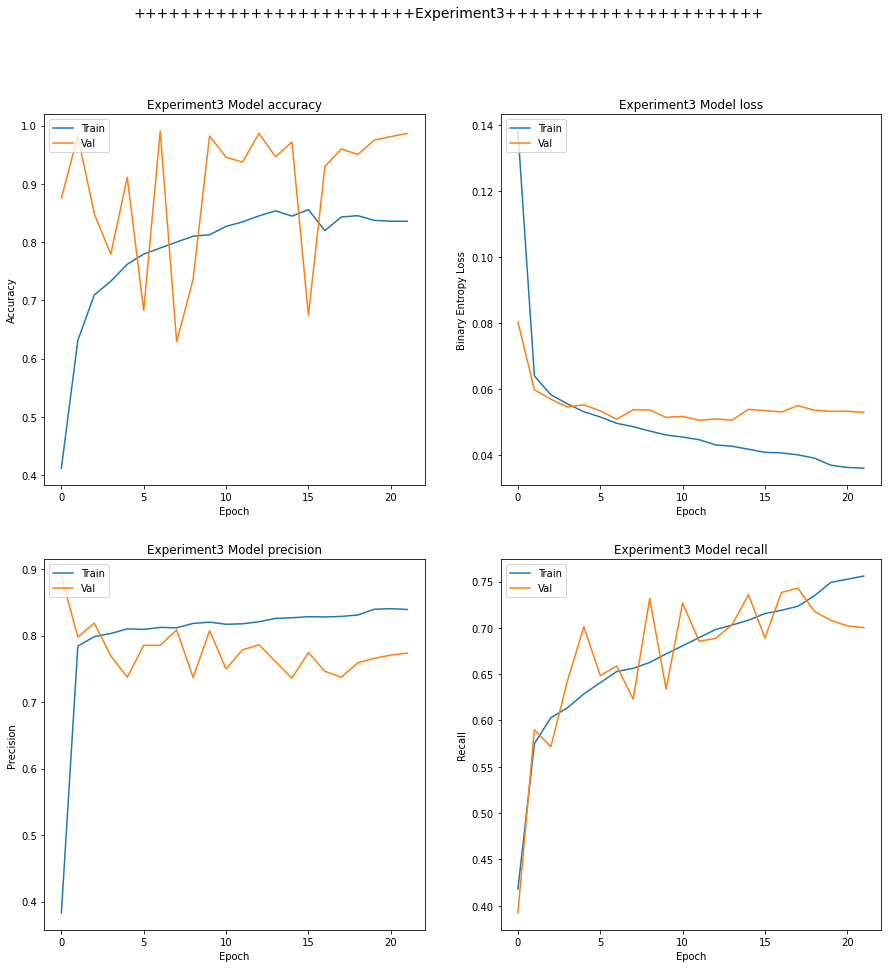

In [35]:
for i in range(4):
    plot_experiments(i)

In [36]:
def find_val_acc(ExperimentNumber):
    #accuracy,loss,precision,recall = [],[],[],[]
    #val_accuracy,val_loss,val_precision,val_recall = [],[],[],[]
    ExperimentNo = "Experiment"+str(ExperimentNumber)
    if ( os.path.exists(ExperimentNo+'_model_history')) :
        
        with open(ExperimentNo+'_model_history', 'rb') as file_history:
            history = pickle.load( file_history )
        for k in range(100):
          if history.get('precision_'+str(k),-1) != -1 :
            precision = 'precision_'+str(k)
            val_precision = 'val_precision_'+str(k)
            recall = 'recall_'+str(k)
            val_recall = 'val_recall_'+str(k)
            break
        accuracy = max(history['accuracy'])
        loss = min(history['loss'])
        precision = max(history[precision])
        recall = max(history[recall])
        val_accuracy = max(history['val_accuracy'])
        val_loss = min(history['val_loss'])
        val_precision = max(history[val_precision])
        val_recall= max(history[val_recall])
        return (accuracy,loss,precision,recall, val_accuracy,val_loss,val_precision,val_recall)
def create_val_acc_matrix():
    Experiment,accuracy,loss,precision,recall = [],[],[],[],[]
    val_accuracy,val_loss,val_precision,val_recall = [],[],[],[]
    for i in range(4):
        accuracy_i,loss_i,precision_i,recall_i, val_accuracy_i,val_loss_i,val_precision_i,val_recall_i =\
        find_val_acc(i)
        Experiment.append(i)
        accuracy.append(accuracy_i)
        loss.append(loss_i)
        precision.append(precision_i)
        recall.append(recall_i)
        val_accuracy.append(val_accuracy_i)
        val_loss.append(val_loss_i)
        val_precision.append(val_precision_i)
        val_recall.append(val_recall_i)
    df = pd.DataFrame()
    df['Experiment'] = Experiment
    df['accuracy'] = accuracy
    df['loss'] = loss
    df['precision'] = precision
    df['recall'] = recall
    df['val_accuracy'] = val_accuracy
    df['val_loss'] = val_loss
    df['val_precision'] = val_precision
    df['val_recall'] = val_recall
    return df


val_acc_matrix = create_val_acc_matrix()

val_acc_matrix

,Experiment,accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall
0,0,0.798038,0.031648,0.859179,0.797382,0.993234,0.051508,0.813613,0.726874
1,1,0.801448,0.036758,0.840535,0.743402,0.992815,0.051942,0.810856,0.756664
2,2,0.762734,0.028894,0.861887,0.823703,0.923758,0.051240,0.801650,0.751646
3,3,0.855748,0.036007,0.840626,0.755929,0.990304,0.050542,0.889758,0.742866


In [70]:
#Try class weight balancing
#Since the number of examples with different classes is much different 
#We will try to use the Experiment0 model with class weight balancing
diff_classes_count = np.sum(Y_train,axis=0)
class_weight = diff_classes_count/sum(diff_classes_count)
class_weight = 1/class_weight
class_weights = dict(enumerate(class_weight))
ExperimentNo = 'Experiment'+str(0)
print("Running ",ExperimentNo)
num_unit_lstm = Experiment_Dic[ExperimentNo]['num_unit_lstm']
num_layers_lstm = Experiment_Dic[ExperimentNo]['num_layers_lstm']
num_dense_layer_units = Experiment_Dic[ExperimentNo]['num_dense_layer_units']
dropout_rate = Experiment_Dic[ExperimentNo]['dropout_rate']
num_dense_layers = Experiment_Dic[ExperimentNo]['num_dense_layers']
cnn_num_filters = Experiment_Dic[ExperimentNo]['cnn_num_filters']
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' +
                                                             os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)
batch_size = 128*8
with strategy.scope():
  precision_obj = keras.metrics.Precision()
  recall_obj = keras.metrics.Recall()
  model = create_model(embedding_matrix,
            num_unit_lstm,
            num_layers_lstm,
            num_dense_layer_units,
            dropout_rate,
            num_dense_layers,
            cnn_num_filters)

  model.compile(
                optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy',precision_obj,recall_obj]
              )
filepath=ExperimentNo+"class_rebalance_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
batch_size = 128 *8
epoch = 50
num_train = (X_train.shape[0]//batch_size)*batch_size
history = model.fit(
                    X_train[:num_train],
                    Y_train[:num_train],
                    validation_split=0.1,
                    callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
                    class_weight = class_weights,
                    batch_size=batch_size,
                    shuffle=True,
                    epochs=epoch)
with open(ExperimentNo+'class_rebalance_model_history', 'wb') as file_history:
    pickle.dump(history.history, file_history)


Running  Experiment0


INFO:tensorflow:Initializing the TPU system: grpc://10.39.252.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.39.252.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/50
  2/126 [..............................] - ETA: 9s - loss: 1.9692 - accuracy: 0.1523 - precision_15: 0.0461 - recall_15: 0.6175WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0041s vs `on_train_batch_end` time: 0.1343s). Check your callbacks.


126/126 [==============================] - ETA: 0s - loss: 0.6831 - accuracy: 0.1659 - precision_15: 0.2103 - recall_15: 0.4653WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0021s vs `on_test_batch_end` time: 0.0435s). Check your callbacks.


126/126 [==============================] - 30s 238ms/step - loss: 0.6831 - accuracy: 0.1659 - precision_15: 0.2103 - recall_15: 0.4653 - val_loss: 0.1087 - val_accuracy: 0.4280 - val_precision_15: 0.7443 - val_recall_15: 0.5083
Epoch 2/50
126/126 [==============================] - 19s 152ms/step - loss: 0.2507 - accuracy: 0.3113 - precision_15: 0.7718 - recall_15: 0.5038 - val_loss: 0.0772 - val_accuracy: 0.2359 - val_precision_15: 0.7804 - val_recall_15: 0.5695
Epoch 3/50
126/126 [==============================] - 21s 166ms/step - loss: 0.1973 - accuracy: 0.4084 - precision_15: 0.7780 - recall_15: 0.5480 - val_loss: 0.0740 - val_accuracy: 0.5433 - val_precision_15: 0.7016 - val_recall_15: 0.6563
Epoch 4/50
126/126 [==============================] - 21s 167ms/step - loss: 0.1765 - accuracy: 0.5252 - precision_15: 0.7929 - recall_15: 0.5468 - val_loss: 0.0608 - val_accuracy: 0.9555 - val_precision_15: 0.7822 - val_recall_15: 0.5945
Epoch 5/50
126/126 [==============================] - 1

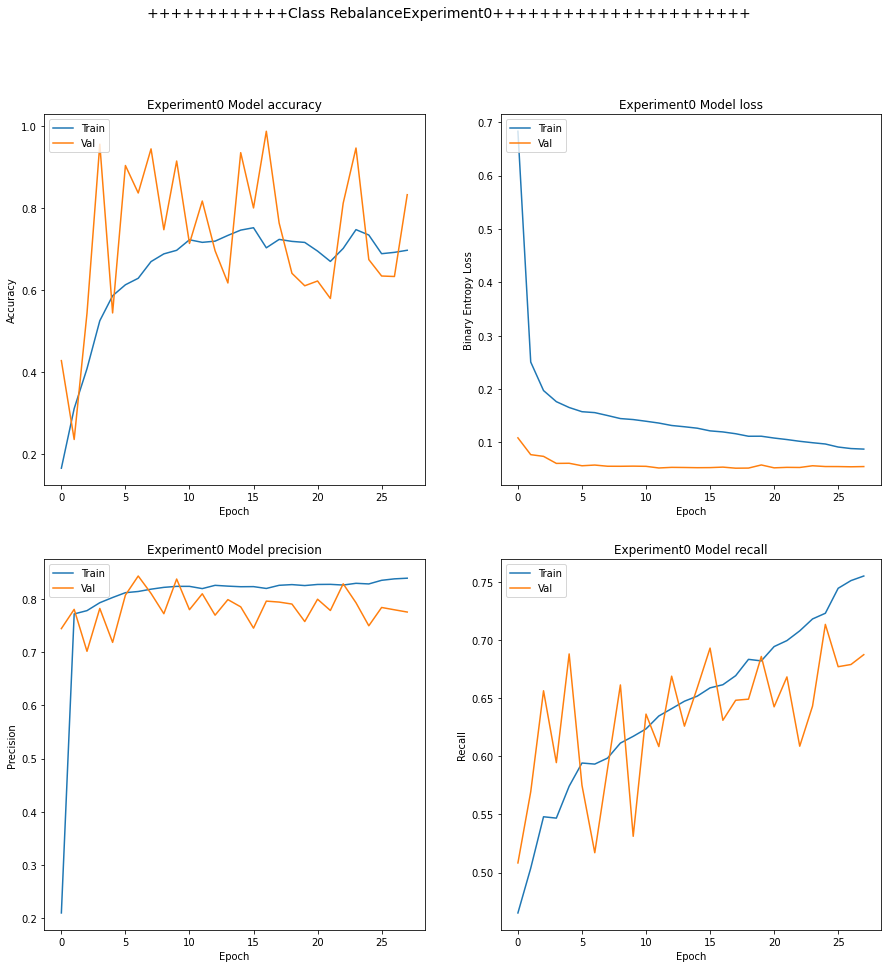

In [71]:

ExperimentNo = "Experiment"+str(0)
if ( os.path.exists(ExperimentNo+'class_rebalance_model_history')) :
    
    with open(ExperimentNo+'class_rebalance_model_history', 'rb') as file_history:
        history = pickle.load( file_history )

    fig, axs = plt.subplots(2, 2,figsize=(15,15))
    fig.suptitle('++++++++++++Class Rebalance'+ExperimentNo+'++++++++++++++++++++++',fontsize=14)
    # Plot training & validation accuracy values
    axs[0, 0].plot(history['accuracy'])
    axs[0, 0].plot(history['val_accuracy'])
    axs[0, 0].set_title(ExperimentNo+' Model accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['Train', 'Val'], loc='upper left')
    #plt.show()

    # Plot training & validation loss values
    axs[0, 1].plot(history['loss'])
    axs[0, 1].plot(history['val_loss'])
    axs[0, 1].set_title(ExperimentNo+' Model loss')
    axs[0, 1].set_ylabel('Binary Entropy Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['Train', 'Val'], loc='upper left')
    #plt.show()


    # Plot training & validation precision values
    for k in range(100):
      if history.get('precision_'+str(k),-1) != -1 :
        precision = 'precision_'+str(k)
        val_precision = 'val_precision_'+str(k)
        recall = 'recall_'+str(k)
        val_recall = 'val_recall_'+str(k)
        break
    axs[1, 0].plot(history[precision])
    axs[1, 0].plot(history[val_precision])
    axs[1, 0].set_title(ExperimentNo+' Model precision')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend(['Train', 'Val'], loc='upper left')
    #plt.show()

    # Plot training & validation recall values
    axs[1, 1].plot(history[recall])
    axs[1, 1].plot(history[val_recall])
    axs[1, 1].set_title(ExperimentNo+' Model recall')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['Train', 'Val'], loc='upper left')
    #plt.show()

In [18]:
#Inference Time
#Get model for Experiment0 created
ExperimentNo = 'Experiment'+str(0)
num_unit_lstm = Experiment_Dic[ExperimentNo]['num_unit_lstm']
num_layers_lstm = Experiment_Dic[ExperimentNo]['num_layers_lstm']
num_dense_layer_units = Experiment_Dic[ExperimentNo]['num_dense_layer_units']
dropout_rate = Experiment_Dic[ExperimentNo]['dropout_rate']
num_dense_layers = Experiment_Dic[ExperimentNo]['num_dense_layers']
cnn_num_filters = Experiment_Dic[ExperimentNo]['cnn_num_filters']
#create model
precision_obj = keras.metrics.Precision()
recall_obj = keras.metrics.Recall()
model = create_model(embedding_matrix,
                   num_unit_lstm,
                   num_layers_lstm,
                   num_dense_layer_units,
                   dropout_rate,
                   num_dense_layers,
                   cnn_num_filters)
    
model.compile(
              optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',precision_obj,recall_obj]
              )
#load best model weights
model.load_weights("Experiment0class_rebalance_weights-improvement-17-0.99.hdf5")

In [73]:
#Run the evaluation on Validation Set
test_loss, test_acc,test_precision,test_recall = \
model.evaluate(X_valid, Y_valid)

  2/499 [..............................] - ETA: 6:22 - loss: 0.0491 - accuracy: 1.0000 - precision_16: 0.9231 - recall_16: 0.7500 WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_test_batch_end` time: 0.2914s). Check your callbacks.


499/499 [==============================] - 148s 297ms/step - loss: 0.0480 - accuracy: 0.9880 - precision_16: 0.8023 - recall_16: 0.6633


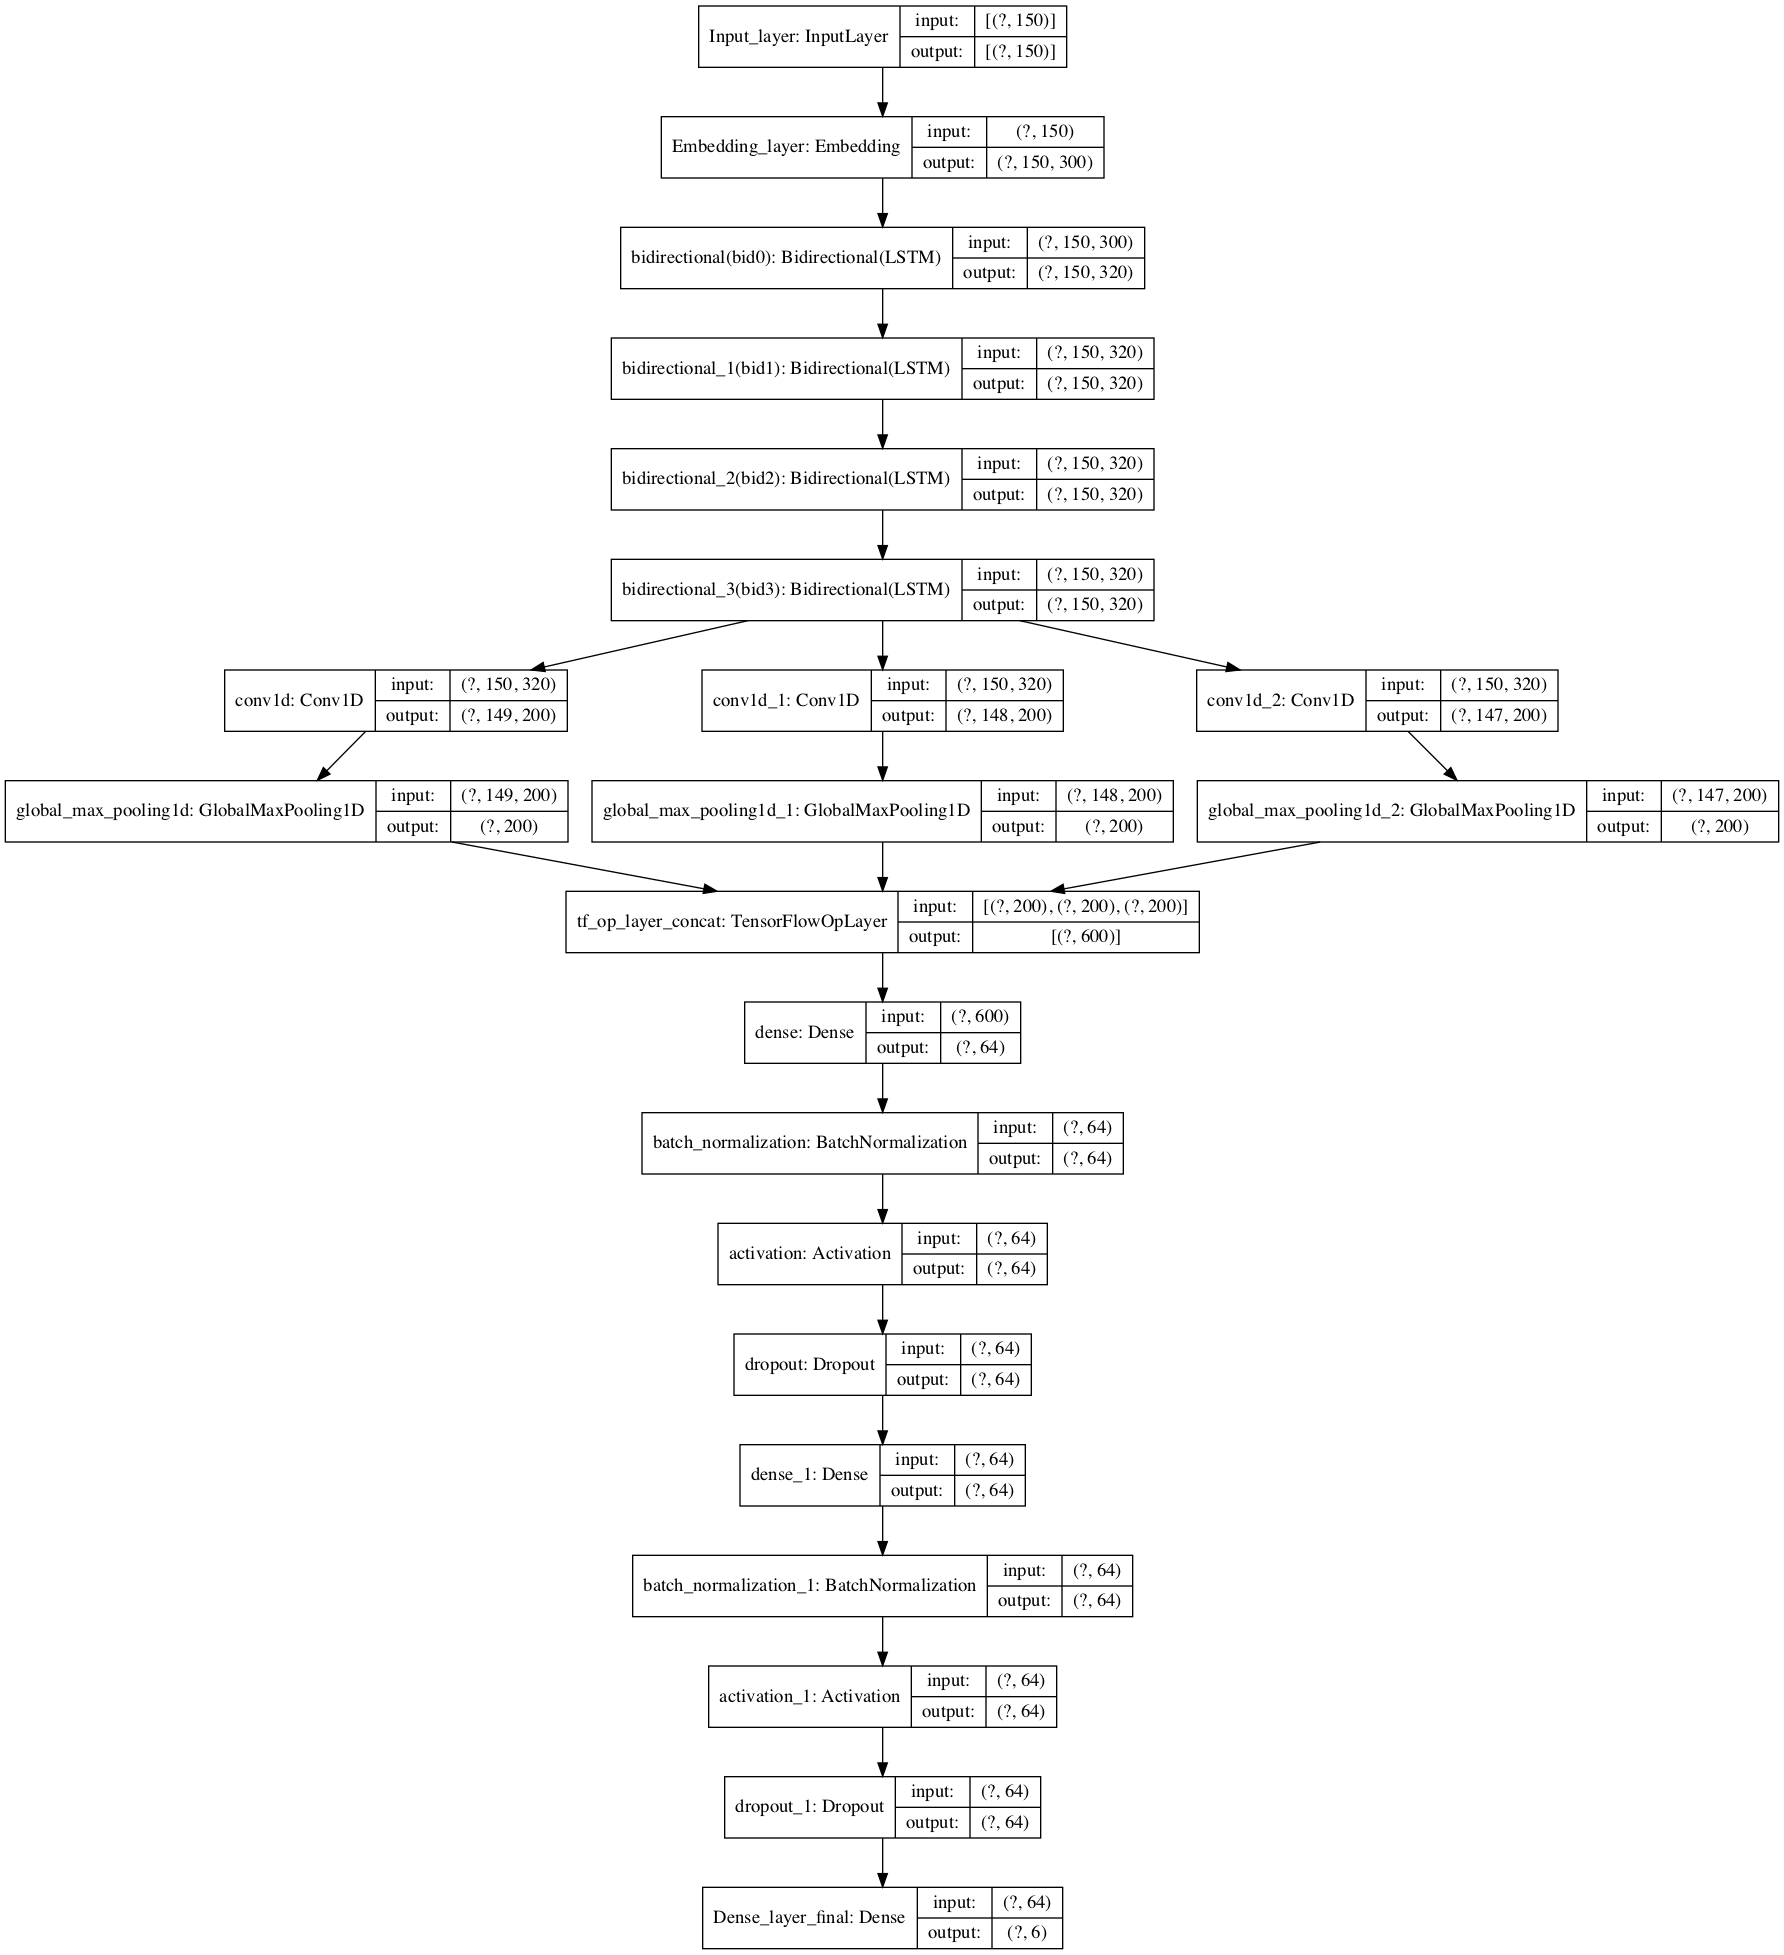

In [19]:
#Print the model
plot_model(model,show_shapes=True,to_file='model.png')

In [74]:
#create submission csv using the model
#First create the padded sequence for the test set 
X_test = test_df['comment_text']

X_test_padded = vectorize_data(tokenizer,X_test,max_len)
X_test_padded.shape


(153164, 150)

In [75]:
#create predictions
predictions = model.predict(X_test_padded,batch_size=1024,verbose=1)

  2/150 [..............................] - ETA: 3:29WARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_predict_batch_end` time: 1.8501s). Check your callbacks.


150/150 [==============================] - 269s 2s/step


In [76]:
#Create submission df
submission_df2 = pd.DataFrame()
submission_df2['id'] = test_df['id']
submission_df2[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = predictions
submission_df2.to_csv('submission2.csv', index=False)